In [41]:
import numpy as np
from mixed import MixAgent
from buffer import MultiAgentReplayBuffer
from OrangeEnv import MultiAgentEnv
import matplotlib.pyplot as plt
import pandas as pd

In [42]:
scenario = "lattice" #博弈所处的环境，一共分为lattice,ba,random,ws四种。
n_agents = 100 #智能体的总数。
AI_rate = 0.8  #智能体为强化学习者的比例。

N_GAMES = 1  #一局演化重复的次数。
MAX_STEPS = 100 #一次演化最多会有多少步

evaluate = True  #控制训练的开关。

init_prob = 0.5
spatial_distirbution_list = [0, 50, 99] #调整输出结果

In [43]:
env = MultiAgentEnv(n_agents, scenario)
actor_dims = []

#waiting for adjustment  
for i in range(n_agents):
    actor_dims.append(env.observation_space[i] * 2)
critic_dims = n_agents * 2

n_actions= 2

In [44]:
#这两个依然有超参数，不过不重要
maddpg_agents = MixAgent(actor_dims, critic_dims, n_agents, n_actions, 
                           fc1=64, fc2=64, AI_rate=AI_rate, 
                           alpha=0.01, beta=0.01, scenario=scenario,
                           chkpt_dir='tmp/mixed/')
memory = MultiAgentReplayBuffer(100000 , critic_dims, actor_dims, 
                        n_actions, n_agents, batch_size=1024 )

In [46]:
#variable for counting, which is not need to adjust.
total_steps = 0
score_history = []
best_score = 0
PRINT_INTERVAL = 100 

In [47]:
if evaluate:
    maddpg_agents.load_checkpoint()

... loading checkpoint ...


In [48]:
for i in range(N_GAMES):
    state, obs = env.reset(init_prob)
    score = 0
    done = [False]*n_agents
    episode_step = 0
    cooperate_counts = [init_prob]
    
    
    actions = np.zeros(n_agents)
    split = int(init_prob * n_agents)
    actions[split: ] = 1.0
    
    while not any(done):
        # if evaluate:
        #     env.render()
            #time.sleep(0.1) # to slow down the action for the video
        if episode_step in spatial_distirbution_list:
            spatial_distirbution = pd.DataFrame(np.array(actions).reshape(int(np.sqrt(n_agents)),-1))
            spatial_distirbution.to_csv('results/spatial_distribution/' + scenario + '/' 
                                        + scenario 
                                        + ", Agents_num = "+ str(n_agents) 
                                        + (', AI-rate = %.2f' % AI_rate) 
                                        + (", eposide= %d" % episode_step)
                                        + " .csv"  , index= False, header= None)
            
        actions = maddpg_agents.choose_action(obs)
        state_, obs_, reward, done, info = env.step(np.array(actions)[:,0])
        cooperate_count = np.count_nonzero(np.array(actions)[:,0] == 0)
        # state = obs_list_to_state_vector(obs)
        # state_ = obs_list_to_state_vector(obs_)
        cooperate_counts.append(cooperate_count / n_agents)

        if episode_step >= MAX_STEPS:
            done = [True]*n_agents

        memory.store_transition(obs, state, actions, reward, obs_, state_, done)

        if total_steps % 100 == 0 and not evaluate:
            maddpg_agents.learn(memory)

        obs = obs_
        state = state_
        
        score = sum(reward)
        total_steps += 1
        episode_step += 1

    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    if not evaluate:
        if avg_score > best_score:
            maddpg_agents.save_checkpoint()
            best_score = avg_score
    if i % PRINT_INTERVAL == 0 and i > 0:
        print('episode', i, 'average score {:.1f}'.format(avg_score))

f:\PYTHON PROGRAM\Orange-MARL\networks.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = T.tensor(state,dtype= T.float32)


In [49]:
actions

[array([1., 0.], dtype=float32),
 array([0., 1.]),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.]),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.]),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.]),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 arr

In [50]:
results = pd.DataFrame(cooperate_counts)
results.to_csv('results/cooperate_counts/' + scenario + '/'+ "Agents_num = "+ str(n_agents) + (', AI-rate = %.2f' % AI_rate) + " .csv"  , index= False)

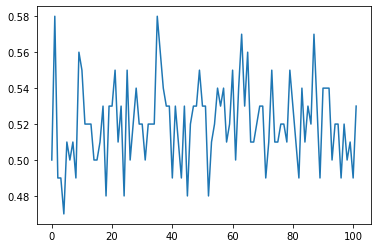

In [51]:
plt.plot(cooperate_counts)